# Table Detection with Gemini

This notebook demonstrates table extraction from both images and PDFs using Google's Gemini API with Pydantic structured outputs.

## Features

1. **Unified Schema**: Uses the same Pydantic schema for both images and PDFs
2. **Structured Output**: Gemini returns properly typed data with bounding boxes and text content
3. **Unified Plotting**: Same visualization function works for both image and PDF results
4. **Model Comparison**: Model name is parameterized to compare different Gemini models

## Usage

### For Images:
```python
result = extract_tables_from_image("your-image.jpg", model="gemini-3-pro-preview")
plot_bounding_boxes("your-image.jpg", result)
```

### For PDFs:
```python
result = extract_tables_from_pdf("your-document.pdf", model="gemini-3-pro-preview")
# Convert PDF page to image first, then visualize
```

## Data Structure

The extraction returns:
- `pages`: List of pages, each containing:
  - `page_number`: Page number
  - `width`, `height`: Page dimensions in pixels
  - `items`: List of table items, each with:
    - `content`: Text content
    - `box_2d`: Bounding box with normalized coordinates (0-1000 scale)
      - `ymin`, `xmin`, `ymax`, `xmax`

In [111]:
# Setup and Schema Definition
from pathlib import Path
from pydantic import BaseModel, Field
from google import genai
from google.genai import types
from PIL import Image, ImageDraw, ImageFont
import json
import time

# Define the Schema using Pydantic
class BoundingBox(BaseModel):
    ymin: int = Field(description="Y coordinate of the top edge (0-1000 scale)")
    xmin: int = Field(description="X coordinate of the left edge (0-1000 scale)")
    ymax: int = Field(description="Y coordinate of the bottom edge (0-1000 scale)")
    xmax: int = Field(description="X coordinate of the right edge (0-1000 scale)")

class TableLineItem(BaseModel):
    content: str = Field(description="The text content of the line item")
    box_2d: BoundingBox

class PageData(BaseModel):
    page_number: int
    width: int = Field(description="Width of the page in pixels")
    height: int = Field(description="Height of the page in pixels")
    items: list[TableLineItem]

class ExtractionResponse(BaseModel):
    pages: list[PageData]

# Initialize client
client = genai.Client()

print("Schema and client initialized successfully!")

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


Schema and client initialized successfully!


In [112]:
def extract_tables_from_image(image_path: str, model: str = "gemini-3-pro-preview") -> ExtractionResponse:
    """
    Extract table data from an image file using Gemini with structured output.
    
    Args:
        image_path: Path to the image file
        model: Gemini model to use (default: "gemini-3-pro-preview")
        
    Returns:
        ExtractionResponse object containing extracted table data
    """
    # Load the image
    image = Image.open(image_path)
    width, height = image.size
    
    prompt = f"""
    Analyze this image, identify the tables and extract all table line items. 
    For every item detected, return the normalized bounding box coordinates on a 0-1000 scale.
    Extract all text content from table cells with their bounding boxes.
    """
    
    # Configure for structured output
    config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=ExtractionResponse
    )
    
    # Measure latency
    start_time = time.time()
    
    # Generate content
    response = client.models.generate_content(
        model=model,
        contents=[image, prompt],
        config=config
    )
    
    latency = time.time() - start_time
    
    # Print metrics
    print(f"\n{'='*60}")
    print(f"Model: {model}")
    print(f"Latency: {latency:.2f}s")
    if hasattr(response, 'usage_metadata') and response.usage_metadata:
        print(f"Input tokens: {response.usage_metadata.prompt_token_count}")
        print(f"Output tokens: {response.usage_metadata.candidates_token_count}")
        print(f"Total tokens: {response.usage_metadata.total_token_count}")
    print(f"{'='*60}\n")
    
    # Parse response
    data = json.loads(response.text)
    return data

print("Image extraction function defined!")

Image extraction function defined!


In [ ]:
def extract_tables_from_pdf(pdf_path: str, model: str = "gemini-3-pro-preview") -> ExtractionResponse:
    """
    Extract table data from a PDF file using Gemini with structured output.
    
    Args:
        pdf_path: Path to the PDF file
        model: Gemini model to use (default: "gemini-3-pro-preview")
        
    Returns:
        ExtractionResponse object containing extracted table data
    """
    filepath = Path(pdf_path)
    
    prompt = f"""
    Analyze this image, identify the tables and extract all table line items.
    For every item detected, return the normalized bounding box coordinates on a 0-1000 scale.
    Also return the estimated pixel width and height of each page.
    """
    
    # Configure for structured output
    config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=ExtractionResponse
    )
    
    # Measure latency
    start_time = time.time()
    
    # Generate content
    response = client.models.generate_content(
        model=model,
        contents=[
            types.Part.from_bytes(
                data=filepath.read_bytes(),
                mime_type='application/pdf',
            ),
            prompt
        ],
        config=config
    )
    
    latency = time.time() - start_time
    
    # Print metrics
    print(f"\n{'='*60}")
    print(f"Model: {model}")
    print(f"Latency: {latency:.2f}s")
    if hasattr(response, 'usage_metadata') and response.usage_metadata:
        print(f"Input tokens: {response.usage_metadata.prompt_token_count}")
        print(f"Output tokens: {response.usage_metadata.candidates_token_count}")
        print(f"Total tokens: {response.usage_metadata.total_token_count}")
    print(f"{'='*60}\n")
    
    # Parse response
    data = json.loads(response.text)
    return data

print("PDF extraction function defined!")

In [113]:
# This is adapted from https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb
def plot_bounding_boxes(image_path: str, extraction_result: dict, page_number: int = 1):
    """
    Plot bounding boxes on an image with text content labels.
    
    Args:
        image_path: Path to the image file
        extraction_result: ExtractionResponse dict from extract_tables_from_image or extract_tables_from_pdf
        page_number: Which page to visualize (default: 1)
    """
    # Load the image
    img = Image.open(image_path)
    actual_width, actual_height = img.size
    
    # Create a drawing object
    draw = ImageDraw.Draw(img)
    
    # Find the page data
    page_data = None
    for page in extraction_result['pages']:
        if page['page_number'] == page_number:
            page_data = page
            break
    
    if not page_data:
        print(f"Page {page_number} not found in extraction results")
        return
    
    # Get dimensions from extraction result
    reported_width = page_data['width']
    reported_height = page_data['height']
    
    print(f"Image actual size: {actual_width}x{actual_height}")
    print(f"Reported size: {reported_width}x{reported_height}")
    print(f"Found {len(page_data['items'])} items")
    
    # Iterate over the bounding boxes
    for i, item in enumerate(page_data['items']):
        box_color = 'red'
        text_color = 'black'
        box = item['box_2d']
        
        # Convert normalized coordinates (0-1000) to absolute coordinates
        # Use reported dimensions as the reference
        abs_y1 = int(box['ymin'] / 1000 * actual_height)
        abs_x1 = int(box['xmin'] / 1000 * actual_width)
        abs_y2 = int(box['ymax'] / 1000 * actual_height)
        abs_x2 = int(box['xmax'] / 1000 * actual_width)
        
        # Ensure coordinates are in correct order
        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1
        
        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1
        
        # Draw the bounding box
        
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), 
            outline=box_color, 
            width=1
        )
        
        # Draw the text content if available
        if 'content' in item and item['content']:
            draw.text((abs_x1, abs_y1 - 10), item['content'], fill=text_color)
    
    # Display the image
    img.show()
    return img

print("Unified plotting function defined!")

Unified plotting function defined!


Extracting tables from image...

Model: gemini-3-pro-preview
Latency: 95.11s
Input tokens: 1131
Output tokens: 4458
Total tokens: 12779


--- Page 1 (1000x950) ---
Found 66 items
Item 1: '2010'
  Location: [115, 472, 141, 526]
Item 2: '2009'
  Location: [115, 625, 141, 679]
Item 3: '2008'
  Location: [115, 776, 141, 830]
Item 4: 'Non-current assets'
  Location: [150, 124, 175, 311]
Item 5: 'Property'
  Location: [187, 124, 213, 210]
  ... and 61 more items


Visualizing results...
Image actual size: 2134x1700
Reported size: 1000x950
Found 66 items


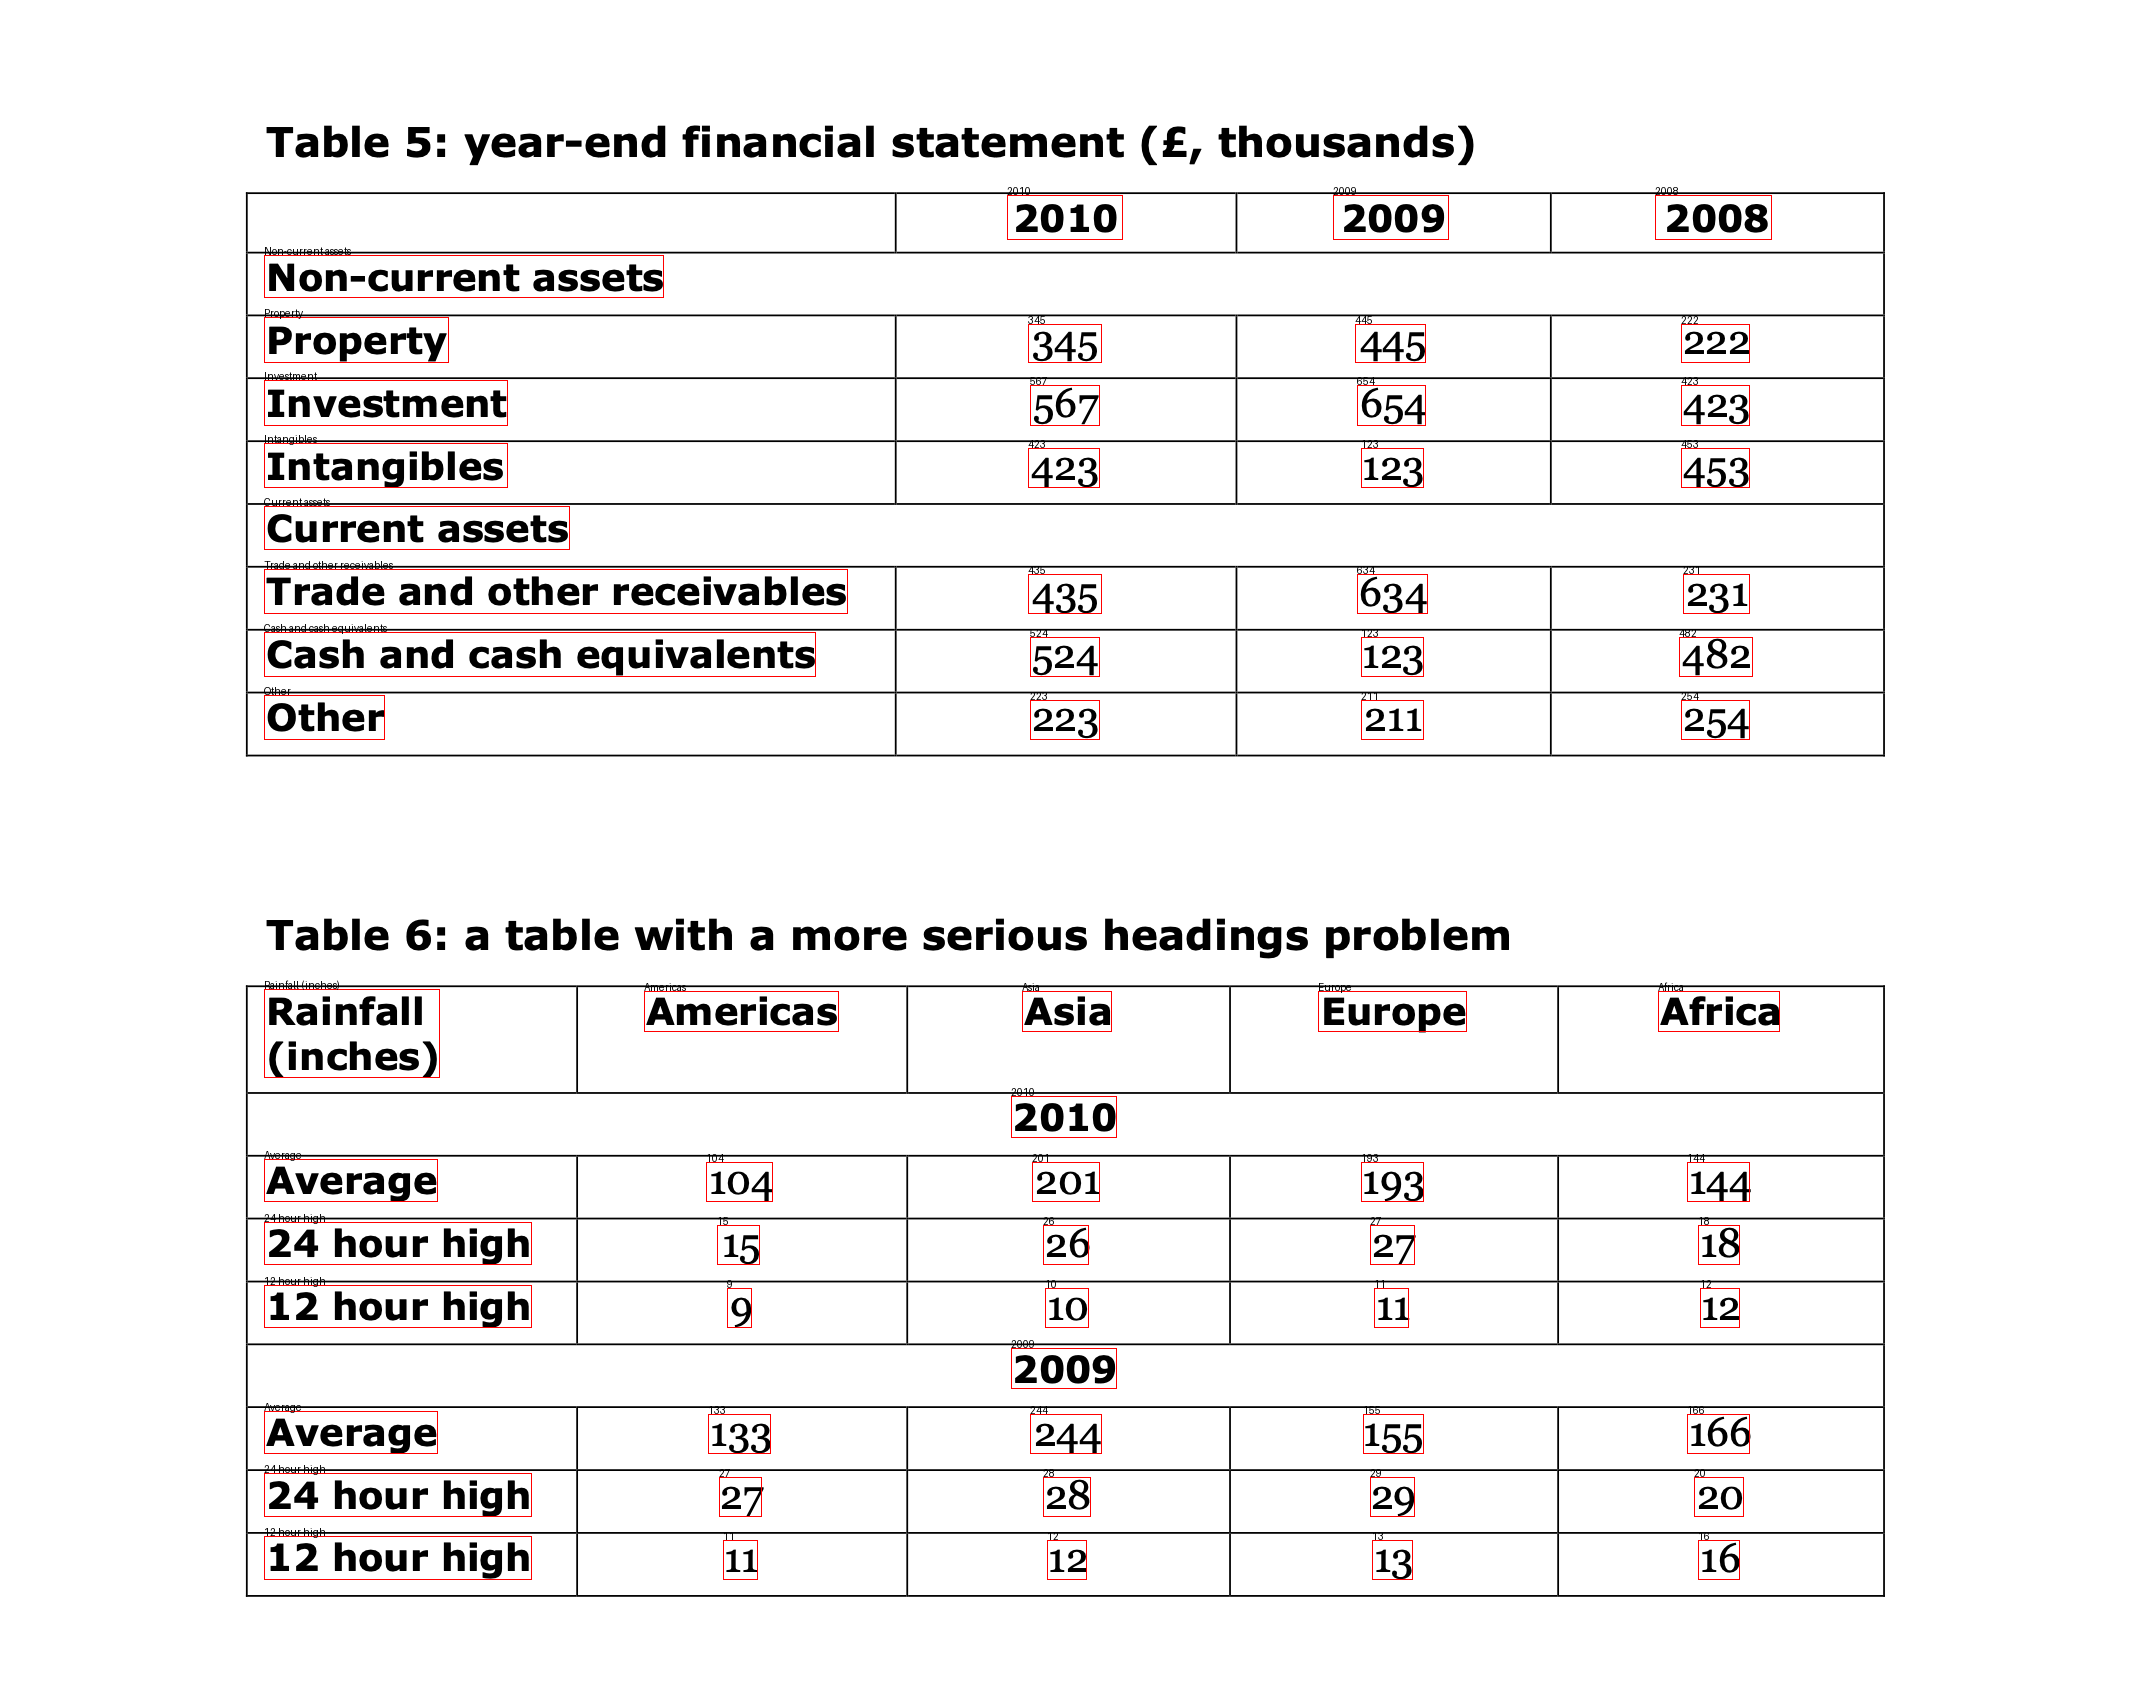

In [114]:
# Example 1: Extract tables from an image
image_path = "Screenshot 2025-12-14 at 2.34.27 PM.png"

print("Extracting tables from image...")
image_result = extract_tables_from_image(image_path)

# Print results
for page in image_result['pages']:
    print(f"\n--- Page {page['page_number']} ({page['width']}x{page['height']}) ---")
    print(f"Found {len(page['items'])} items")
    
    # Show first few items
    for i, item in enumerate(page['items'][:5]):
        box = item['box_2d']
        print(f"Item {i+1}: '{item['content']}'")
        print(f"  Location: [{box['ymin']}, {box['xmin']}, {box['ymax']}, {box['xmax']}]")
    
    if len(page['items']) > 5:
        print(f"  ... and {len(page['items']) - 5} more items")

# Visualize results
print("\n\nVisualizing results...")
plot_bounding_boxes(image_path, image_result, page_number=1)